In [3]:
#import our libraries
!pip install tensorflow
!pip install keras
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import GRU

In [4]:
data = pd.read_csv("indexProcessed.csv", sep=",")
data

,Index,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD
0,HSI,1986-12-31,2568.300049,2568.300049,2568.300049,2568.300049,2568.300049,0.0,333.879006
1,HSI,1987-01-02,2540.100098,2540.100098,2540.100098,2540.100098,2540.100098,0.0,330.213013
2,HSI,1987-01-05,2552.399902,2552.399902,2552.399902,2552.399902,2552.399902,0.0,331.811987
3,HSI,1987-01-06,2583.899902,2583.899902,2583.899902,2583.899902,2583.899902,0.0,335.906987
4,HSI,1987-01-07,2607.100098,2607.100098,2607.100098,2607.100098,2607.100098,0.0,338.923013
...,...,...,...,...,...,...,...,...,...
104219,J203.JO,2021-05-25,66054.921880,66812.453130,66022.976560,66076.679690,66076.679690,0.0,4625.367578
104220,J203.JO,2021-05-26,66076.679690,66446.367190,66030.351560,66108.226560,66108.226560,0.0,4627.575859
104221,J203.JO,2021-05-27,66108.226560,66940.250000,66102.546880,66940.250000,66940.250000,0.0,4685.817500
104222,J203.JO,2021-05-28,66940.250000,67726.562500,66794.609380,67554.859380,67554.859380,0.0,4728.840157


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104224 entries, 0 to 104223
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Index      104224 non-null  object 
 1   Date       104224 non-null  object 
 2   Open       104224 non-null  float64
 3   High       104224 non-null  float64
 4   Low        104224 non-null  float64
 5   Close      104224 non-null  float64
 6   Adj Close  104224 non-null  float64
 7   Volume     104224 non-null  float64
 8   CloseUSD   104224 non-null  float64
dtypes: float64(7), object(2)
memory usage: 7.2+ MB


In [6]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume,CloseUSD
count,104224.000000,104224.000000,104224.000000,104224.000000,104224.000000,1.042240e+05,104224.000000
mean,8015.353334,8063.324234,7962.581120,8014.366642,8014.161269,1.347646e+09,3046.729177
std,9140.563404,9196.575802,9082.767802,9140.609758,9140.720456,4.427662e+09,3747.865623
min,54.869999,54.869999,54.869999,54.869999,54.869999,0.000000e+00,10.204900
25%,2046.887756,2057.213990,2037.185943,2047.506470,2047.358490,0.000000e+00,320.460898
50%,5772.140137,5812.764892,5725.199951,5773.710205,5773.710205,9.529000e+05,1371.598486
75%,10487.377445,10552.179690,10416.092287,10488.622560,10488.622560,2.064676e+08,4383.045241
max,68775.062500,69403.750000,68516.992190,68775.062500,68775.062500,9.440374e+10,18934.376173


In [7]:
#look for N/A values
data.isna().sum()

Index        0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
CloseUSD     0
dtype: int64

### Preprocess data

In [8]:
# Set random seed for numpy:
np.random.seed(42)

# Set random seed for tensorFlow
tf.random.set_seed(24)

In [9]:
#Verify the type of our date column
type(data.Date[0])

str

In [10]:
#Change Date type to datetime
data["Date"] = pd.to_datetime(data["Date"])

display(data.dtypes)
display(data[["Date"]].sample(5))

Index                object
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
CloseUSD            float64
dtype: object

,Date
24066,1977-07-19
8264,2020-06-29
43916,1977-03-23
69723,1994-03-28
77538,2011-09-26


In [11]:
data.Index.unique()

array(['HSI', 'NYA', 'IXIC', '000001.SS', 'N225', 'N100', '399001.SZ',
       'GSPTSE', 'NSEI', 'GDAXI', 'SSMI', 'TWII', 'J203.JO'], dtype=object)

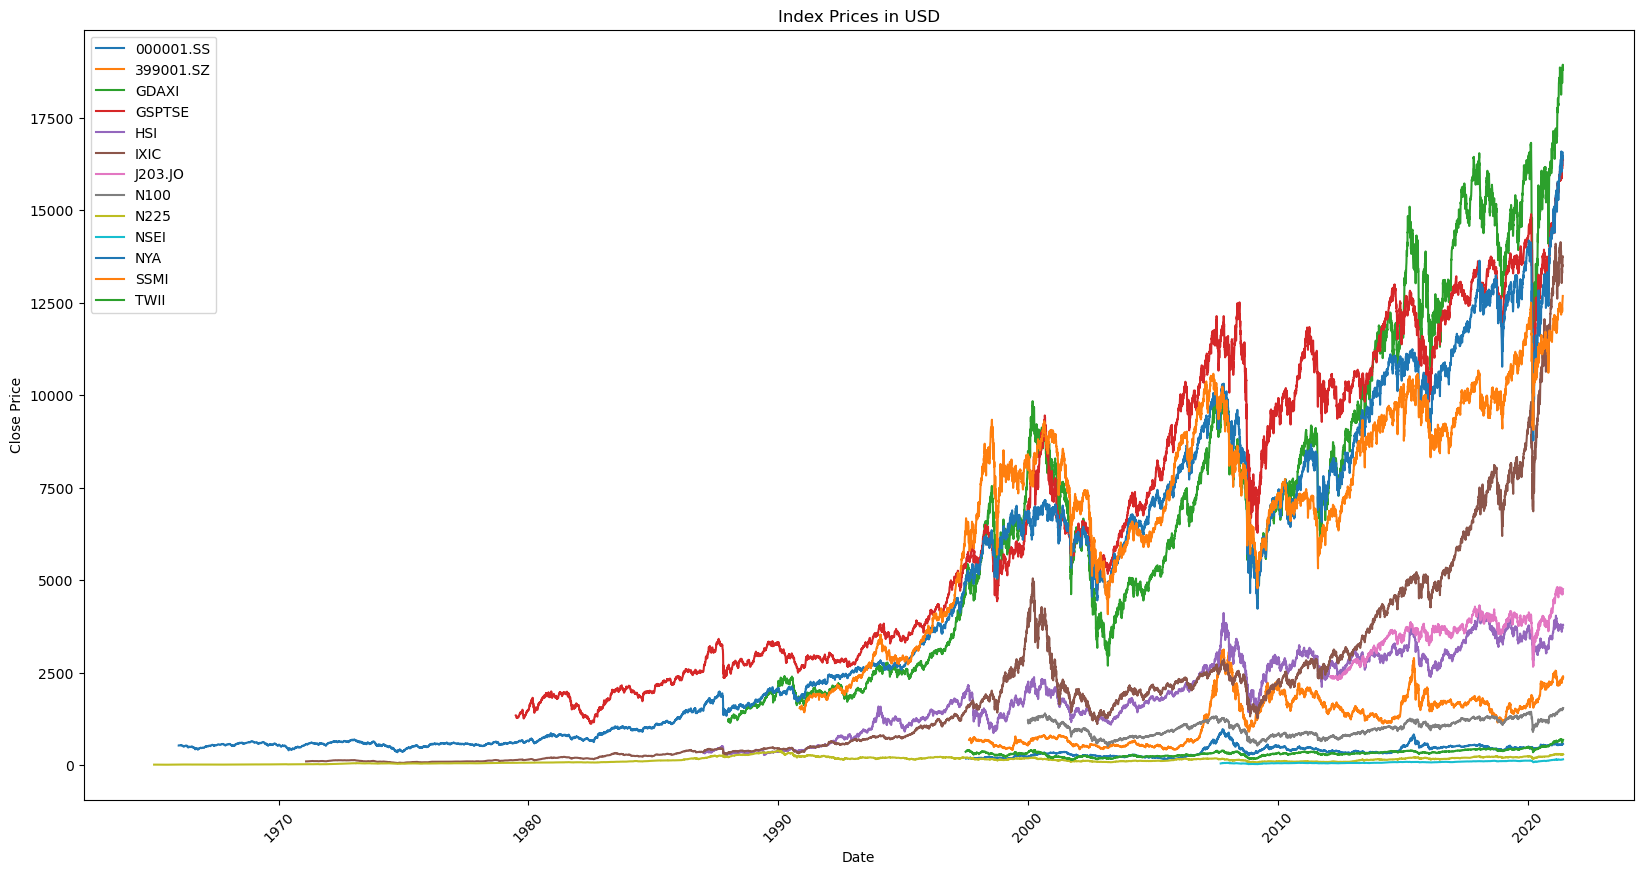

In [12]:
# Group the data by the stocks column
grouped = data.groupby('Index')

#define figsize
plt.figure(figsize=(20, 10))

# Plot each stock separately
for stock, info in grouped:
    plt.plot(info['Date'], info['CloseUSD'], label=stock)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.title('Index Prices in USD')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [13]:
#Separete the datasets by indexes
N100 = data[data['Index'] == "N100"].copy()
HSI = data[data['Index'] == "HSI"].copy()
NYA = data[data['Index'] == "NYA"].copy()
IXIC = data[data['Index'] == "IXIC"].copy()
N225 = data[data['Index'] == "N225"].copy()
GSPTSE = data[data['Index'] == "GSPTSE"].copy()
NSEI = data[data['Index'] == "NSEI"].copy()
GDAXI = data[data['Index'] == "GDAXI"].copy()
SSMI = data[data['Index'] == "SSMI"].copy()
TWII = data[data['Index'] == "TWII"].copy()
SSE = data[data['Index'] == "000001.SS"].copy()
JSE = data[data['Index'] == "J203.JO"].copy()
SZSE = data[data['Index'] == "399001.SZ"].copy()

In [14]:
#Chante data index to column Index
HSI.set_index("Date", inplace=True)
HSI.sample(5)

,Index,Open,High,Low,Close,Adj Close,Volume,CloseUSD
Date,,,,,,,,
2001-01-31,HSI,15916.419920,16106.709960,15905.509770,16102.349610,16102.349610,0.000000e+00,2093.305449
2003-02-26,HSI,9156.799805,9163.330078,9097.490234,9116.280273,9116.280273,1.299270e+08,1185.116435
2016-02-22,HSI,19374.240230,19524.970700,19374.240230,19464.089840,19464.089840,1.207462e+09,2530.331679
2012-02-17,HSI,21503.589840,21546.730470,21381.689450,21491.619140,21491.619140,1.590263e+09,2793.910488
1992-11-17,HSI,6285.700195,6285.700195,6046.700195,6088.500000,6088.500000,0.000000e+00,791.505000


In [15]:
closed_HSI = HSI[["CloseUSD"]].copy()
closed_HSI.shape

(8492, 1)

**Data Exploration**

In [16]:
closed_HSI.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8492 entries, 1986-12-31 to 2021-05-31
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CloseUSD  8492 non-null   float64
dtypes: float64(1)
memory usage: 132.7 KB


In [17]:
closed_HSI.describe()

,CloseUSD
count,8492.000000
mean,1976.078732
std,1056.477228
min,246.337003
25%,1203.639150
50%,1846.016885
75%,2920.320318
max,4310.035742


In [18]:
closed_HSI.describe()

,CloseUSD
count,8492.000000
mean,1976.078732
std,1056.477228
min,246.337003
25%,1203.639150
50%,1846.016885
75%,2920.320318
max,4310.035742


In [19]:
closed_HSI.head()
#data starts in 1986

,CloseUSD
Date,
1986-12-31,333.879006
1987-01-02,330.213013
1987-01-05,331.811987
1987-01-06,335.906987
1987-01-07,338.923013


In [20]:
split_time = int(len(closed_HSI.CloseUSD)*0.25)   # split 25% of our data

train = closed_HSI[:-split_time]
test = closed_HSI[-split_time:]

# Remove last 25% of the training dataset for validation:
val = train[-split_time:]
train = train[:-split_time]

print(f"Shape of train data: {train.shape}")
print(f"Shape of val data: {val.shape}")
print(f"Shape of test data: {test.shape}")

Shape of train data: (4246, 1)
Shape of val data: (2123, 1)
Shape of test data: (2123, 1)


In [21]:
to_groupHSI = closed_HSI.copy()
to_groupHSI["Year"] = to_groupHSI.index.year
grouped_HSI = to_groupHSI.groupby('Year').mean()
grouped_HSI

,CloseUSD
Year,
1986,333.879006
1987,378.043118
1988,332.232036
1989,363.066377
1990,394.246230
1991,493.752633
1992,712.312694
1993,969.687961
1994,1239.172842


<AxesSubplot:xlabel='Year'>

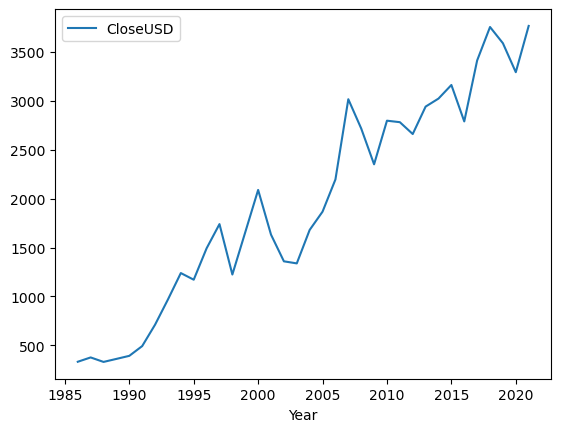

In [22]:
grouped_HSI.plot()

In [23]:
percentage_change = grouped_HSI["CloseUSD"].pct_change()
percentage_change

Year
1986         NaN
1987    0.132276
1988   -0.121180
1989    0.092810
1990    0.085879
1991    0.252397
1992    0.442651
1993    0.361323
1994    0.277909
1995   -0.054744
1996    0.273483
1997    0.165684
1998   -0.295855
1999    0.352105
2000    0.261001
2001   -0.218606
2002   -0.166883
2003   -0.015571
2004    0.255310
2005    0.111014
2006    0.176109
2007    0.373228
2008   -0.099062
2009   -0.134713
2010    0.189489
2011   -0.005450
2012   -0.043526
2013    0.105302
2014    0.027879
2015    0.045975
2016   -0.117738
2017    0.223242
2018    0.100172
2019   -0.044158
2020   -0.082471
2021    0.143588
Name: CloseUSD, dtype: float64

In [24]:
total_return = ((closed_HSI.tail(1).iloc[0,0]-closed_HSI.head(1).iloc[0,0])/closed_HSI.head(1).iloc[0,0])*100
f"The value of the total return is: {total_return.round(2)}%"

'The value of the total return is: 1035.06%'

**Modelling**

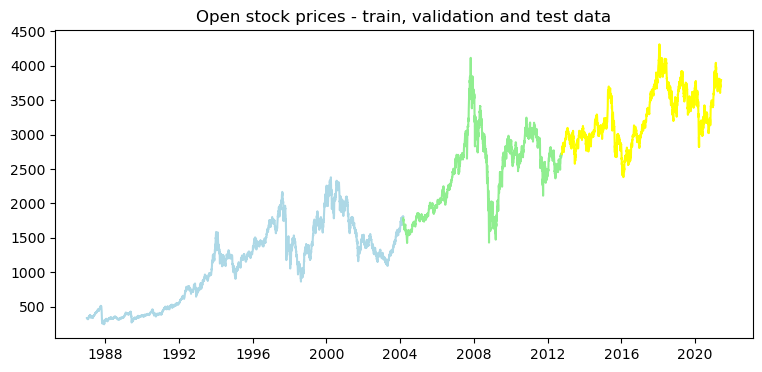

In [25]:
plt.figure(figsize=(9,4))
plt.plot(train, color="lightblue")
plt.plot(val, color="lightgreen")
plt.plot(test, color="yellow")
plt.title("Open stock prices - train, validation and test data")
plt.show()

In [26]:
#reshape data with MinMaxScaler()
scaler = MinMaxScaler()

train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

print(f"Shape of train: {train.shape}")
print(f"Shape of val: {val.shape}")
print(f"Shape of test: {test.shape}")

Shape of train: (4246, 1)
Shape of val: (2123, 1)
Shape of test: (2123, 1)


In [27]:
#Prepare data for training

timesteps = 30  # number of time steps to look back
batch_size = 32  # number of samples per batch

train_generator = TimeseriesGenerator(train, train, length=timesteps, batch_size=batch_size)
val_generator = TimeseriesGenerator(val, val, length=timesteps, batch_size=batch_size)
test_generator = TimeseriesGenerator(test, test, length=timesteps, batch_size=batch_size)

# Shared attributes:
loss_function = 'mse'  
optimizer = 'adam'  
metrics = ['mae']
epochs = 50

num_samples, num_input_features = train.shape

In [28]:
# Shared attributes:
loss_function = 'mse'  
optimizer = 'adam'  
metrics = ['mae']
epochs = 50

num_samples, num_input_features = train.shape

In [29]:
#Define our model architecture

rnn_model = Sequential()
rnn_model.add(SimpleRNN(units=128, input_shape=(num_input_features, 1), return_sequences=True))
rnn_model.add(Dense(1))

rnn_model.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 128)            16640     
                                                                 
 dense (Dense)               (None, 1, 1)              129       
                                                                 
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________


In [30]:
history_rnn_model = rnn_model.fit_generator(
    train_generator, 
    validation_data=val_generator, 
    epochs=epochs
)

rnn_model.save('rnn_model.h5')

/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/1311352504.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_rnn_model = rnn_model.fit_generator(
2023-06-27 20:26:27.971821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/50
130/132 [============================>.] - ETA: 0s - loss: 0.0089 - mae: 0.0613

2023-06-27 20:26:32.732002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


132/132 [==============================] - 5s 24ms/step - loss: 0.0089 - mae: 0.0612 - val_loss: 0.0137 - val_mae: 0.0723
Epoch 2/50
132/132 [==============================] - 3s 24ms/step - loss: 0.0028 - mae: 0.0355 - val_loss: 0.0073 - val_mae: 0.0567
Epoch 3/50
132/132 [==============================] - 3s 24ms/step - loss: 0.0024 - mae: 0.0320 - val_loss: 0.0069 - val_mae: 0.0605
Epoch 4/50
132/132 [==============================] - 3s 19ms/step - loss: 0.0022 - mae: 0.0313 - val_loss: 0.0108 - val_mae: 0.0828
Epoch 5/50
132/132 [==============================] - 3s 23ms/step - loss: 0.0025 - mae: 0.0338 - val_loss: 0.0063 - val_mae: 0.0563
Epoch 6/50
132/132 [==============================] - 3s 24ms/step - loss: 0.0022 - mae: 0.0317 - val_loss: 0.0058 - val_mae: 0.0540
Epoch 7/50
132/132 [==============================] - 3s 24ms/step - loss: 0.0023 - mae: 0.0327 - val_loss: 0.0127 - val_mae: 0.0924
Epoch 8/50
132/132 [==============================] - 5s 36ms/step - loss: 0.001

In [31]:
def evaluate_model(model, model_name, train_gen, val_gen, test_gen, verbose=False):
    """Utility function that prints loss and MAE scores of a given model. Returns the results in a dataframe."""
    if verbose:
        print(f"Evaluation of {model_name}:")
    
    train_loss, train_mae = model.evaluate_generator(train_gen)
    val_loss, val_mae = model.evaluate_generator(val_gen)
    test_loss, test_mae = model.evaluate_generator(test_gen)
    
    if verbose:
        print(f"\nTest loss: {round(test_loss, 4)} \t | \ttest mae: {round(test_mae, 4)}")
        print(f"Val loss: {round(val_loss, 4)} \t | \tval mae: {round(val_mae, 4)}")
        print(f"Train loss: {round(train_loss, 4)} \t | \ttrain mae: {round(train_mae, 4)}")
        
    return pd.DataFrame.from_dict(
        [
            {
                "model_name": model_name,
                "test_loss": round(test_loss, 4),
                "test_mae": round(test_mae, 4),
                "val_loss": round(val_loss, 4),
                "val_mae": round(val_mae, 4),
                "train_loss": round(train_loss, 4),
                "train_mae": round(train_mae, 4)
            }
        ]
    )

In [32]:
results_rnn = evaluate_model(
    rnn_model,
    "RNN_MODEL",
    train_generator,
    val_generator,
    test_generator,
    verbose=True 
)

results_rnn

Evaluation of RNN_MODEL:


/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/1871078561.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)
2023-06-27 20:29:34.227479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/1871078561.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
2023-06-27 20:29:35.188018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CP


Test loss: 0.0292 	 | 	test mae: 0.1545
Val loss: 0.0119 	 | 	val mae: 0.086
Train loss: 0.0019 	 | 	train mae: 0.0286


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,RNN_MODEL,0.0292,0.1545,0.0119,0.086,0.0019,0.0286


In [33]:
train_preds = rnn_model.predict(train)
val_preds = rnn_model.predict(val)
test_preds = rnn_model.predict(test)

print(f"Shape of train_preds: {train_preds.shape}")
print(f"Shape of val_preds: {val_preds.shape}")
print(f"Shape of test_preds: {test_preds.shape}")

67/67 [==============================] - 0s 3ms/step
Shape of train_preds: (4246, 1, 1)
Shape of val_preds: (2123, 1, 1)
Shape of test_preds: (2123, 1, 1)


In [34]:
def plot_predictions(data_dict, indexes_dict, title, vars_to_plot=["train_preds", "val_preds", "test_preds", "train", "val", "test"]):
    # Note: this function assumes that data_d contains the info regarding true labels for train, val and test,
    # as well as predictions for train, val and test.
    color_code = {
        "train": "lightblue",
        "val": "lightgreen",
        "test": "yellow",
        "train_preds": "darkblue",
        "val_preds": "darkgreen",
        "test_preds": "orange"
    }
    
    plt.figure(figsize=(12,4))
    
    for col in vars_to_plot:
        plt.plot(indexes_dict[col], data_dict[col], color=color_code[col])
        
    
    plt.title(title)
    plt.show()

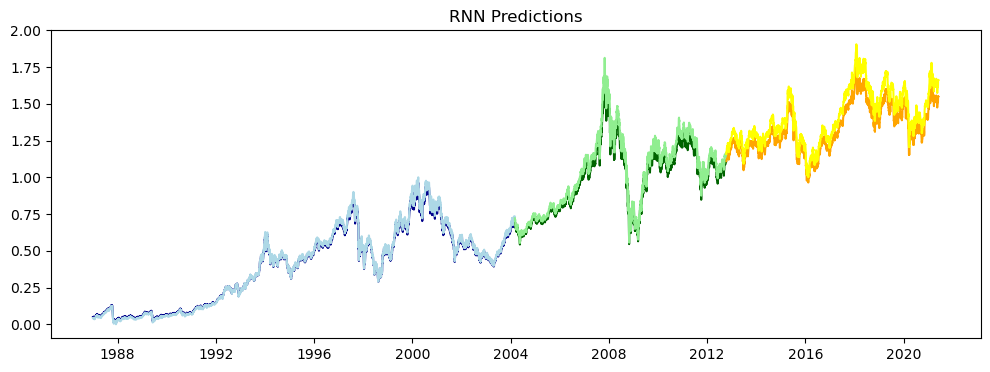

In [35]:
dataRNN = {
    "train": train, "val": val, "test": test, 
    "train_preds": train_preds.ravel(), "val_preds": val_preds.ravel(), "test_preds": test_preds.ravel()
}

datetime_indexes = {
    "train": closed_HSI[:-split_time*2].index,
    "train_preds": closed_HSI[:-split_time*2].index,
    "val": closed_HSI[-split_time * 2: -split_time].index,
    "val_preds": closed_HSI[-split_time * 2: -split_time].index,
    "test": closed_HSI[-split_time:].index,
    "test_preds": closed_HSI[-split_time:].index
}

plot_predictions(dataRNN, datetime_indexes, "RNN Predictions")

In [36]:
gru_model = Sequential()
gru_model.add(GRU(units=128, input_shape=(num_input_features, 1), return_sequences=True))
gru_model.add(Dense(1))

gru_model.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
gru_model.summary()

2023-06-27 20:29:40.148638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-27 20:29:40.153905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-27 20:29:40.163412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 128)            50304     
                                                                 
 dense_1 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 50,433
Trainable params: 50,433
Non-trainable params: 0
_________________________________________________________________


In [37]:
history_gru_model = gru_model.fit_generator(
    train_generator, 
    validation_data=val_generator, 
    epochs=epochs
)

gru_model.save('gru_model.h5')

Epoch 1/50


/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/3670477540.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_gru_model = gru_model.fit_generator(
2023-06-27 20:29:40.542369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-27 20:29:40.945232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-27 2

132/132 [==============================] - ETA: 0s - loss: 0.0213 - mae: 0.0871

2023-06-27 20:29:49.368355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-27 20:29:49.785726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-27 20:29:49.788885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

132/132 [==============================] - 10s 54ms/step - loss: 0.0213 - mae: 0.0871 - val_loss: 0.0266 - val_mae: 0.0837
Epoch 2/50
132/132 [==============================] - 7s 52ms/step - loss: 0.0045 - mae: 0.0392 - val_loss: 0.0179 - val_mae: 0.0759
Epoch 3/50
132/132 [==============================] - 8s 57ms/step - loss: 0.0037 - mae: 0.0387 - val_loss: 0.0130 - val_mae: 0.0669
Epoch 4/50
132/132 [==============================] - 10s 74ms/step - loss: 0.0035 - mae: 0.0402 - val_loss: 0.0100 - val_mae: 0.0596
Epoch 5/50
132/132 [==============================] - 7s 54ms/step - loss: 0.0027 - mae: 0.0347 - val_loss: 0.0092 - val_mae: 0.0633
Epoch 6/50
132/132 [==============================] - 6s 47ms/step - loss: 0.0024 - mae: 0.0327 - val_loss: 0.0075 - val_mae: 0.0566
Epoch 7/50
132/132 [==============================] - 6s 43ms/step - loss: 0.0022 - mae: 0.0316 - val_loss: 0.0074 - val_mae: 0.0600
Epoch 8/50
132/132 [==============================] - 8s 58ms/step - loss: 0.0

In [38]:
results_gru = evaluate_model(
    gru_model,
    "GRU_MODEL",
    train_generator,
    val_generator,
    test_generator,
    verbose=True 
)

results_gru

Evaluation of GRU_MODEL:


/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/1871078561.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)
2023-06-27 20:35:38.824050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/1871078561.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
2023-06-27 20:35:40.471997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CP


Test loss: 0.013 	 | 	test mae: 0.0982
Val loss: 0.0077 	 | 	val mae: 0.0662
Train loss: 0.0018 	 | 	train mae: 0.027


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,GRU_MODEL,0.013,0.0982,0.0077,0.0662,0.0018,0.027


In [39]:
results = pd.concat([results_rnn, results_gru])
results

,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,RNN_MODEL,0.0292,0.1545,0.0119,0.0860,0.0019,0.0286
0,GRU_MODEL,0.0130,0.0982,0.0077,0.0662,0.0018,0.0270


In [40]:
train_preds_gru = gru_model.predict(train)
val_preds_gru = gru_model.predict(val)
test_preds_gru = gru_model.predict(test)

  1/133 [..............................] - ETA: 57s

2023-06-27 20:35:42.365995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-27 20:35:42.368136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-27 20:35:42.369903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

67/67 [==============================] - 0s 2ms/step


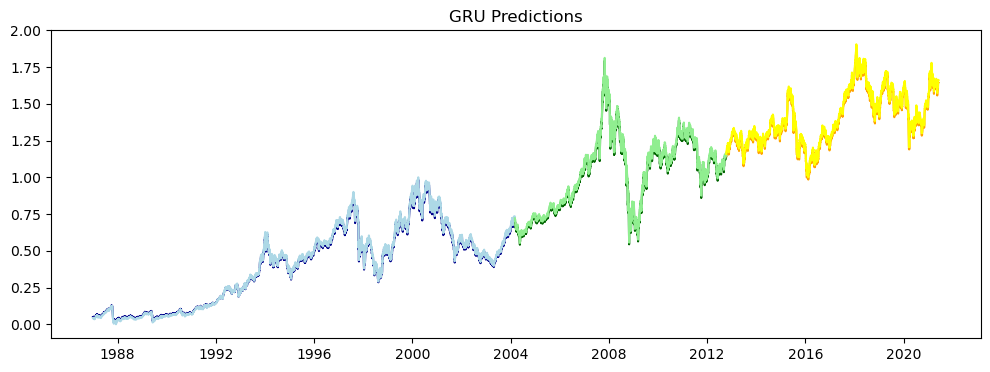

In [41]:
dataGRU = {
    "train": train, "val": val, "test": test, 
    "train_preds": train_preds_gru.ravel(), "val_preds": val_preds_gru.ravel(), "test_preds": test_preds_gru.ravel()
}

plot_predictions(dataGRU, datetime_indexes, "GRU Predictions")

In [42]:
gru_model2 = Sequential()
gru_model2.add(GRU(units=128, input_shape=(num_input_features, 1), return_sequences=True))
gru_model2.add(Dense(1))
gru_model2.add(Dense(1))
gru_model2.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
gru_model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 1, 128)            50304     
                                                                 
 dense_2 (Dense)             (None, 1, 1)              129       


2023-06-27 20:35:43.886234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-27 20:35:43.889959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-27 20:35:43.892387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

                                                                 
 dense_3 (Dense)             (None, 1, 1)              2         
                                                                 
Total params: 50,435
Trainable params: 50,435
Non-trainable params: 0
_________________________________________________________________


In [43]:
history_gru_model2 = gru_model2.fit_generator(
    train_generator, 
    validation_data=val_generator, 
    epochs=epochs
)

gru_model2.save('gru_model2.h5')

Epoch 1/50


/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/2556741204.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_gru_model2 = gru_model2.fit_generator(
2023-06-27 20:35:44.221738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-27 20:35:44.606077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-27

131/132 [============================>.] - ETA: 0s - loss: 0.0188 - mae: 0.0894

2023-06-27 20:35:51.472777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-27 20:35:51.791242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-27 20:35:51.793310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

132/132 [==============================] - 8s 38ms/step - loss: 0.0187 - mae: 0.0891 - val_loss: 0.0302 - val_mae: 0.0929
Epoch 2/50
132/132 [==============================] - 5s 34ms/step - loss: 0.0051 - mae: 0.0427 - val_loss: 0.0193 - val_mae: 0.0721
Epoch 3/50
132/132 [==============================] - 6s 44ms/step - loss: 0.0039 - mae: 0.0400 - val_loss: 0.0146 - val_mae: 0.0690
Epoch 4/50
132/132 [==============================] - 4s 34ms/step - loss: 0.0030 - mae: 0.0356 - val_loss: 0.0156 - val_mae: 0.0897
Epoch 5/50
132/132 [==============================] - 5s 40ms/step - loss: 0.0030 - mae: 0.0382 - val_loss: 0.0092 - val_mae: 0.0581
Epoch 6/50
132/132 [==============================] - 5s 35ms/step - loss: 0.0031 - mae: 0.0377 - val_loss: 0.0096 - val_mae: 0.0688
Epoch 7/50
132/132 [==============================] - 4s 32ms/step - loss: 0.0028 - mae: 0.0364 - val_loss: 0.0128 - val_mae: 0.0885
Epoch 8/50
132/132 [==============================] - 4s 33ms/step - loss: 0.002

In [44]:
results_gru2 = evaluate_model(
    gru_model2,
    "GRU_MODEL2",
    train_generator,
    val_generator,
    test_generator,
    verbose=True 
)

results_gru2

Evaluation of GRU_MODEL2:


/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/1871078561.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)
2023-06-27 20:40:26.311771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/1871078561.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
2023-06-27 20:40:27.723750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CP


Test loss: 0.0096 	 | 	test mae: 0.0814
Val loss: 0.0064 	 | 	val mae: 0.0577
Train loss: 0.0017 	 | 	train mae: 0.0264


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,GRU_MODEL2,0.0096,0.0814,0.0064,0.0577,0.0017,0.0264


In [45]:
results = pd.concat([results, results_gru2])
results

,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,RNN_MODEL,0.0292,0.1545,0.0119,0.0860,0.0019,0.0286
0,GRU_MODEL,0.0130,0.0982,0.0077,0.0662,0.0018,0.0270
0,GRU_MODEL2,0.0096,0.0814,0.0064,0.0577,0.0017,0.0264


In [46]:
train_preds_gru2 = gru_model2.predict(train)
val_preds_gru2 = gru_model2.predict(val)
test_preds_gru2 = gru_model2.predict(test)

  1/133 [..............................] - ETA: 59s

2023-06-27 20:40:29.650612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-27 20:40:29.652586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-27 20:40:29.655242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

67/67 [==============================] - 0s 2ms/step


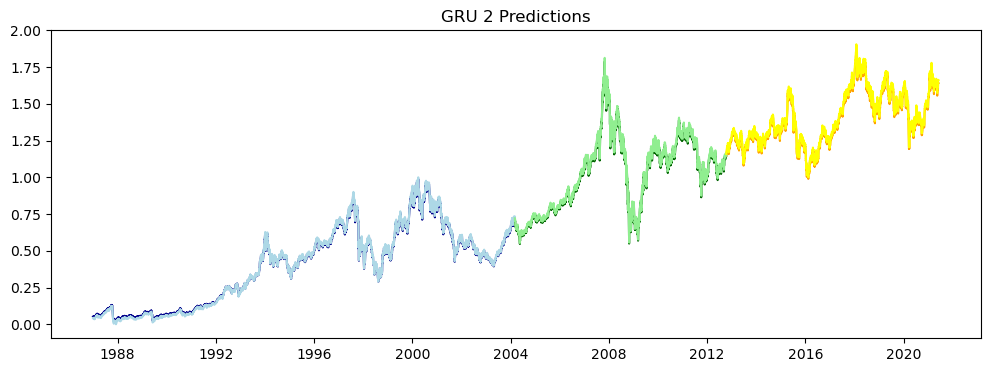

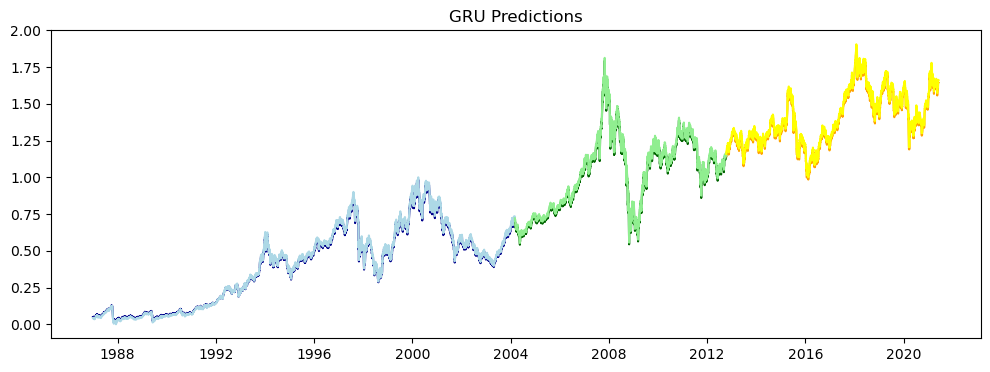

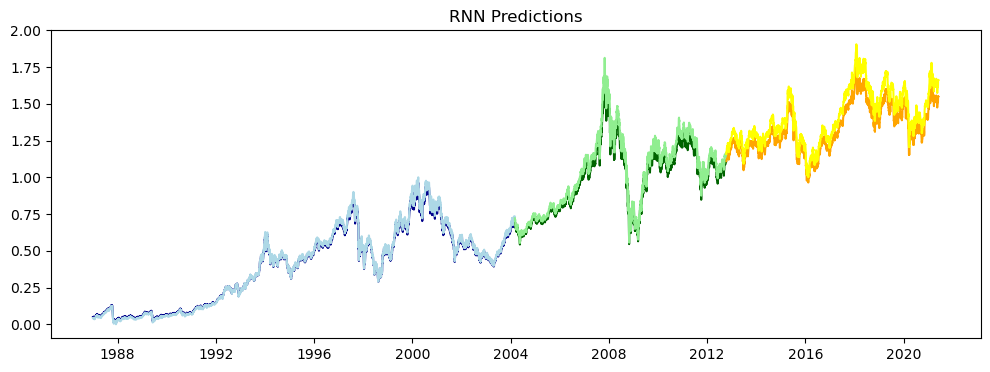

In [47]:
dataGRU2 = {
    "train": train, "val": val, "test": test, 
    "train_preds": train_preds_gru2.ravel(), "val_preds": val_preds_gru2.ravel(), "test_preds": test_preds_gru2.ravel()
}

plot_predictions(dataGRU2, datetime_indexes, "GRU 2 Predictions")
plot_predictions(dataGRU, datetime_indexes, "GRU Predictions")
plot_predictions(dataRNN, datetime_indexes, "RNN Predictions")

In [48]:
# Define LSTM's architecture here:
from tensorflow.keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(units=128, input_shape=(num_input_features, 1), return_sequences=True))
lstm_model.add(Dense(1))

lstm_model.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            66560     
                                                                 
 dense_4 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


2023-06-27 20:40:32.282505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-27 20:40:32.283963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-27 20:40:32.285506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [49]:
history_lstm_model = lstm_model.fit_generator(
    train_generator, 
    validation_data=val_generator, 
    epochs=epochs
)

lstm_model.save('lstm_model.h5')

Epoch 1/50


/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/510226361.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_lstm_model = lstm_model.fit_generator(
2023-06-27 20:40:32.456000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-27 20:40:32.751505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-27 

132/132 [==============================] - ETA: 0s - loss: 0.0185 - mae: 0.0815

2023-06-27 20:40:40.486655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-27 20:40:40.764529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-27 20:40:40.766337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

132/132 [==============================] - 9s 55ms/step - loss: 0.0185 - mae: 0.0815 - val_loss: 0.0437 - val_mae: 0.1053
Epoch 2/50
132/132 [==============================] - 7s 53ms/step - loss: 0.0074 - mae: 0.0515 - val_loss: 0.0276 - val_mae: 0.0851
Epoch 3/50
132/132 [==============================] - 7s 50ms/step - loss: 0.0049 - mae: 0.0414 - val_loss: 0.0220 - val_mae: 0.0877
Epoch 4/50
132/132 [==============================] - 8s 58ms/step - loss: 0.0045 - mae: 0.0425 - val_loss: 0.0206 - val_mae: 0.1002
Epoch 5/50
132/132 [==============================] - 7s 52ms/step - loss: 0.0035 - mae: 0.0374 - val_loss: 0.0123 - val_mae: 0.0658
Epoch 6/50
132/132 [==============================] - 6s 47ms/step - loss: 0.0028 - mae: 0.0345 - val_loss: 0.0106 - val_mae: 0.0662
Epoch 7/50
132/132 [==============================] - 8s 58ms/step - loss: 0.0026 - mae: 0.0337 - val_loss: 0.0080 - val_mae: 0.0565
Epoch 8/50
132/132 [==============================] - 7s 54ms/step - loss: 0.002

In [50]:
results_lstm = evaluate_model(
    lstm_model,
    "LSTM_MODEL",
    train_generator,
    val_generator,
    test_generator,
    verbose=True 
)

results_lstm

Evaluation of LSTM_MODEL:


/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/1871078561.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)
2023-06-27 20:47:48.911421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/1871078561.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
2023-06-27 20:47:51.176717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CP


Test loss: 0.0319 	 | 	test mae: 0.1629
Val loss: 0.0136 	 | 	val mae: 0.0944
Train loss: 0.002 	 | 	train mae: 0.0299


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,LSTM_MODEL,0.0319,0.1629,0.0136,0.0944,0.002,0.0299


In [51]:
results = pd.concat([results, results_lstm])
results

,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,RNN_MODEL,0.0292,0.1545,0.0119,0.0860,0.0019,0.0286
0,GRU_MODEL,0.0130,0.0982,0.0077,0.0662,0.0018,0.0270
0,GRU_MODEL2,0.0096,0.0814,0.0064,0.0577,0.0017,0.0264
0,LSTM_MODEL,0.0319,0.1629,0.0136,0.0944,0.0020,0.0299


In [52]:

# Filter the dataset to keep entries after the year 2000 
df = closed_HSI[closed_HSI.index > '2000-01-01']
df

,CloseUSD
Date,
2000-01-03,2258.052012
2000-01-04,2219.466640
2000-01-05,2060.073565
2000-01-06,1969.919961
2000-01-07,2002.731884
...,...
2021-05-25,3758.411719
2021-05-26,3791.581270
2021-05-27,3784.715899


In [53]:
split_time_df = int(len(df.CloseUSD)*0.25)   # split 25% of our data

train_new = df[:-split_time_df]
test_new = df[-split_time_df:]

# Remove last 25% of the training dataset for validation:
val_new = train_new[-split_time_df:]
train_new = train_new[:-split_time_df]

print(f"Shape of train data: {train_new.shape}")
print(f"Shape of val data: {val_new.shape}")
print(f"Shape of test data: {test_new.shape}")

Shape of train data: (2636, 1)
Shape of val data: (1318, 1)
Shape of test data: (1318, 1)


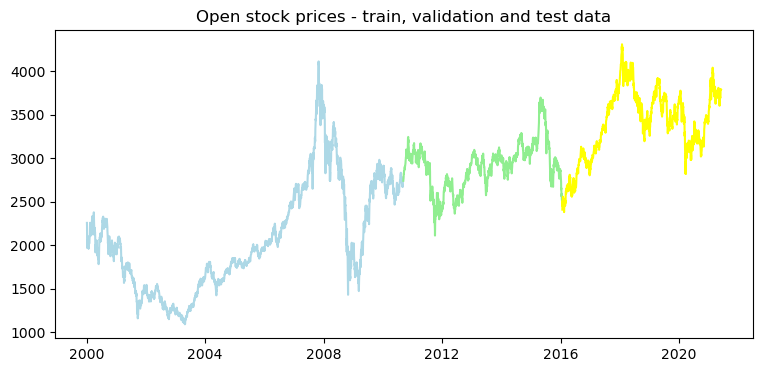

In [54]:
plt.figure(figsize=(9,4))
plt.plot(train_new, color="lightblue")
plt.plot(val_new, color="lightgreen")
plt.plot(test_new, color="yellow")
plt.title("Open stock prices - train, validation and test data")
plt.show()

In [55]:
#reshape data with MinMaxScaler()
scaler = MinMaxScaler()

train_new = scaler.fit_transform(train_new)
val_new = scaler.transform(val_new)
test_new = scaler.transform(test_new)

print(f"Shape of train: {train_new.shape}")
print(f"Shape of val: {val_new.shape}")
print(f"Shape of test: {test_new.shape}")

Shape of train: (2636, 1)
Shape of val: (1318, 1)
Shape of test: (1318, 1)


In [56]:
#Prepare data for training

timesteps_new = 30  # number of time steps to look back
batch_size_new = 32  # number of samples per batch

train_generator_new = TimeseriesGenerator(train_new, train_new, length=timesteps_new, batch_size=batch_size_new)
val_generator_new = TimeseriesGenerator(val_new, val_new, length=timesteps_new, batch_size=batch_size_new)
test_generator_new = TimeseriesGenerator(test_new, test_new, length=timesteps_new, batch_size=batch_size_new)

In [91]:
history_rnn_model_new = rnn_model.fit_generator(
    train_generator_new, 
    validation_data=val_generator_new, 
    epochs=epochs
)

rnn_model_new.save('rnn_model_new.h5')

/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/1084784191.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_rnn_model_new = rnn_model.fit_generator(
2023-06-28 20:09:48.404429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/50
82/82 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0342

2023-06-28 20:09:49.888890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


82/82 [==============================] - 1s 16ms/step - loss: 0.0025 - mae: 0.0342 - val_loss: 0.0034 - val_mae: 0.0483
Epoch 2/50
82/82 [==============================] - 1s 14ms/step - loss: 0.0025 - mae: 0.0334 - val_loss: 0.0021 - val_mae: 0.0343
Epoch 3/50
82/82 [==============================] - 1s 15ms/step - loss: 0.0025 - mae: 0.0347 - val_loss: 0.0020 - val_mae: 0.0329
Epoch 4/50
82/82 [==============================] - 1s 15ms/step - loss: 0.0023 - mae: 0.0330 - val_loss: 0.0032 - val_mae: 0.0438
Epoch 5/50
82/82 [==============================] - 1s 15ms/step - loss: 0.0023 - mae: 0.0333 - val_loss: 0.0021 - val_mae: 0.0351
Epoch 6/50
82/82 [==============================] - 1s 11ms/step - loss: 0.0024 - mae: 0.0330 - val_loss: 0.0025 - val_mae: 0.0390
Epoch 7/50
82/82 [==============================] - 1s 17ms/step - loss: 0.0025 - mae: 0.0336 - val_loss: 0.0022 - val_mae: 0.0357
Epoch 8/50
82/82 [==============================] - 1s 18ms/step - loss: 0.0026 - mae: 0.0342 

In [93]:
results_rnn_new = evaluate_model(
    rnn_model,
    "RNN_MODEL_New",
    train_generator_new,
    val_generator_new,
    test_generator_new,
    verbose=True 
)

results_rnn_new

Evaluation of RNN_MODEL_New:


/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/1871078561.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)
2023-06-28 20:56:52.852167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/1871078561.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
2023-06-28 20:56:53.704827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CP


Test loss: 0.0024 	 | 	test mae: 0.0368
Val loss: 0.002 	 | 	val mae: 0.0328
Train loss: 0.0022 	 | 	train mae: 0.0313


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,RNN_MODEL_New,0.0024,0.0368,0.002,0.0328,0.0022,0.0313


In [60]:
results = pd.concat([results, results_rnn_new])
results

,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,RNN_MODEL,0.0292,0.1545,0.0119,0.0860,0.0019,0.0286
0,GRU_MODEL,0.0130,0.0982,0.0077,0.0662,0.0018,0.0270
0,GRU_MODEL2,0.0096,0.0814,0.0064,0.0577,0.0017,0.0264
0,LSTM_MODEL,0.0319,0.1629,0.0136,0.0944,0.0020,0.0299
0,RNN_MODEL_New,0.0033,0.0460,0.0020,0.0339,0.0022,0.0315


In [61]:
history_gru_model_new = gru_model.fit_generator(
    train_generator_new, 
    validation_data=val_generator_new, 
    epochs=epochs
)

gru_model.save('gru_model_new.h5')

Epoch 1/50
 1/82 [..............................] - ETA: 4s - loss: 5.2713e-04 - mae: 0.0183

/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/2870789418.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_gru_model_new = gru_model.fit_generator(
2023-06-27 20:49:29.394157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


81/82 [============================>.] - ETA: 0s - loss: 0.0026 - mae: 0.0366

2023-06-27 20:49:32.905272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


82/82 [==============================] - 4s 49ms/step - loss: 0.0026 - mae: 0.0364 - val_loss: 0.0019 - val_mae: 0.0320
Epoch 2/50
82/82 [==============================] - 4s 51ms/step - loss: 0.0027 - mae: 0.0370 - val_loss: 0.0020 - val_mae: 0.0332
Epoch 3/50
82/82 [==============================] - 3s 37ms/step - loss: 0.0024 - mae: 0.0329 - val_loss: 0.0021 - val_mae: 0.0350
Epoch 4/50
82/82 [==============================] - 3s 36ms/step - loss: 0.0025 - mae: 0.0344 - val_loss: 0.0025 - val_mae: 0.0397
Epoch 5/50
82/82 [==============================] - 3s 41ms/step - loss: 0.0025 - mae: 0.0340 - val_loss: 0.0024 - val_mae: 0.0369
Epoch 6/50
82/82 [==============================] - 3s 34ms/step - loss: 0.0024 - mae: 0.0332 - val_loss: 0.0019 - val_mae: 0.0325
Epoch 7/50
82/82 [==============================] - 3s 39ms/step - loss: 0.0025 - mae: 0.0346 - val_loss: 0.0022 - val_mae: 0.0348
Epoch 8/50
82/82 [==============================] - 3s 40ms/step - loss: 0.0023 - mae: 0.0324 

In [62]:
results_gru_new = evaluate_model(
    gru_model,
    "GRU_MODEL_new",
    train_generator_new,
    val_generator_new,
    test_generator_new,
    verbose=True 
)

results_gru_new

Evaluation of GRU_MODEL_new:


/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/1871078561.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)
2023-06-27 20:52:58.336867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/1871078561.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
2023-06-27 20:52:59.289392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CP


Test loss: 0.0039 	 | 	test mae: 0.0514
Val loss: 0.0024 	 | 	val mae: 0.0382
Train loss: 0.0023 	 | 	train mae: 0.0336


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,GRU_MODEL_new,0.0039,0.0514,0.0024,0.0382,0.0023,0.0336


In [63]:
results = pd.concat([results, results_gru_new])
results

,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,RNN_MODEL,0.0292,0.1545,0.0119,0.0860,0.0019,0.0286
0,GRU_MODEL,0.0130,0.0982,0.0077,0.0662,0.0018,0.0270
0,GRU_MODEL2,0.0096,0.0814,0.0064,0.0577,0.0017,0.0264
0,LSTM_MODEL,0.0319,0.1629,0.0136,0.0944,0.0020,0.0299
0,RNN_MODEL_New,0.0033,0.0460,0.0020,0.0339,0.0022,0.0315
0,GRU_MODEL_new,0.0039,0.0514,0.0024,0.0382,0.0023,0.0336


In [64]:
history_gru_model2_new = gru_model2.fit_generator(
    train_generator_new, 
    validation_data=val_generator_new, 
    epochs=epochs
)

gru_model2.save('gru_model2.h5')

Epoch 1/50
 1/82 [..............................] - ETA: 4s - loss: 4.2733e-04 - mae: 0.0162

/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/2993950295.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_gru_model2_new = gru_model2.fit_generator(
2023-06-27 20:53:00.688307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


81/82 [============================>.] - ETA: 0s - loss: 0.0029 - mae: 0.0380

2023-06-27 20:53:03.841699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


82/82 [==============================] - 4s 44ms/step - loss: 0.0029 - mae: 0.0380 - val_loss: 0.0020 - val_mae: 0.0323
Epoch 2/50
82/82 [==============================] - 3s 36ms/step - loss: 0.0029 - mae: 0.0379 - val_loss: 0.0021 - val_mae: 0.0343
Epoch 3/50
82/82 [==============================] - 3s 38ms/step - loss: 0.0024 - mae: 0.0344 - val_loss: 0.0021 - val_mae: 0.0336
Epoch 4/50
82/82 [==============================] - 4s 44ms/step - loss: 0.0024 - mae: 0.0343 - val_loss: 0.0020 - val_mae: 0.0326
Epoch 5/50
82/82 [==============================] - 3s 41ms/step - loss: 0.0024 - mae: 0.0329 - val_loss: 0.0020 - val_mae: 0.0340
Epoch 6/50
82/82 [==============================] - 3s 36ms/step - loss: 0.0024 - mae: 0.0331 - val_loss: 0.0020 - val_mae: 0.0330
Epoch 7/50
82/82 [==============================] - 3s 40ms/step - loss: 0.0025 - mae: 0.0347 - val_loss: 0.0030 - val_mae: 0.0429
Epoch 8/50
82/82 [==============================] - 4s 46ms/step - loss: 0.0025 - mae: 0.0346 

In [65]:
results_gru2_new = evaluate_model(
    gru_model2,
    "GRU_MODEL2_New",
    train_generator_new,
    val_generator_new,
    test_generator_new,
    verbose=True 
)

results_gru2_new

Evaluation of GRU_MODEL2_New:


/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/1871078561.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)
2023-06-27 20:56:24.725471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/1871078561.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
2023-06-27 20:56:25.754536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CP


Test loss: 0.0033 	 | 	test mae: 0.0466
Val loss: 0.0021 	 | 	val mae: 0.0346
Train loss: 0.0022 	 | 	train mae: 0.0316


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,GRU_MODEL2_New,0.0033,0.0466,0.0021,0.0346,0.0022,0.0316


In [66]:
results = pd.concat([results, results_gru2_new])
results

,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,RNN_MODEL,0.0292,0.1545,0.0119,0.0860,0.0019,0.0286
0,GRU_MODEL,0.0130,0.0982,0.0077,0.0662,0.0018,0.0270
0,GRU_MODEL2,0.0096,0.0814,0.0064,0.0577,0.0017,0.0264
0,LSTM_MODEL,0.0319,0.1629,0.0136,0.0944,0.0020,0.0299
0,RNN_MODEL_New,0.0033,0.0460,0.0020,0.0339,0.0022,0.0315
0,GRU_MODEL_new,0.0039,0.0514,0.0024,0.0382,0.0023,0.0336
0,GRU_MODEL2_New,0.0033,0.0466,0.0021,0.0346,0.0022,0.0316


In [67]:
history_lstm_model = lstm_model.fit_generator(
    train_generator_new, 
    validation_data=val_generator_new, 
    epochs=epochs
)

lstm_model.save('lstm_model.h5')

Epoch 1/50
 1/82 [..............................] - ETA: 6s - loss: 0.0034 - mae: 0.0437

/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/2782138291.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_lstm_model = lstm_model.fit_generator(
2023-06-27 20:56:26.756185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


82/82 [==============================] - ETA: 0s - loss: 0.0022 - mae: 0.0321

2023-06-27 20:56:30.800364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


82/82 [==============================] - 5s 65ms/step - loss: 0.0022 - mae: 0.0321 - val_loss: 0.0022 - val_mae: 0.0353
Epoch 2/50
82/82 [==============================] - 4s 48ms/step - loss: 0.0025 - mae: 0.0335 - val_loss: 0.0019 - val_mae: 0.0319
Epoch 3/50
82/82 [==============================] - 4s 49ms/step - loss: 0.0025 - mae: 0.0337 - val_loss: 0.0020 - val_mae: 0.0339
Epoch 4/50
82/82 [==============================] - 5s 64ms/step - loss: 0.0024 - mae: 0.0340 - val_loss: 0.0020 - val_mae: 0.0335
Epoch 5/50
82/82 [==============================] - 6s 74ms/step - loss: 0.0023 - mae: 0.0329 - val_loss: 0.0020 - val_mae: 0.0337
Epoch 6/50
82/82 [==============================] - 4s 54ms/step - loss: 0.0023 - mae: 0.0329 - val_loss: 0.0019 - val_mae: 0.0322
Epoch 7/50
82/82 [==============================] - 4s 54ms/step - loss: 0.0023 - mae: 0.0329 - val_loss: 0.0019 - val_mae: 0.0319
Epoch 8/50
82/82 [==============================] - 4s 51ms/step - loss: 0.0024 - mae: 0.0330 

In [68]:
results_lstm_new = evaluate_model(
    lstm_model,
    "LSTM_MODEL_new",
    train_generator_new,
    val_generator_new,
    test_generator_new,
    verbose=True 
)

results_lstm_new

Evaluation of LSTM_MODEL_new:


/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/1871078561.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)
2023-06-27 21:01:10.135930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/1871078561.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
2023-06-27 21:01:12.786721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CP


Test loss: 0.0031 	 | 	test mae: 0.0443
Val loss: 0.002 	 | 	val mae: 0.0333
Train loss: 0.0022 	 | 	train mae: 0.0312


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,LSTM_MODEL_new,0.0031,0.0443,0.002,0.0333,0.0022,0.0312


In [69]:
results = pd.concat([results, results_lstm_new])
results

,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,RNN_MODEL,0.0292,0.1545,0.0119,0.0860,0.0019,0.0286
0,GRU_MODEL,0.0130,0.0982,0.0077,0.0662,0.0018,0.0270
0,GRU_MODEL2,0.0096,0.0814,0.0064,0.0577,0.0017,0.0264
0,LSTM_MODEL,0.0319,0.1629,0.0136,0.0944,0.0020,0.0299
0,RNN_MODEL_New,0.0033,0.0460,0.0020,0.0339,0.0022,0.0315
0,GRU_MODEL_new,0.0039,0.0514,0.0024,0.0382,0.0023,0.0336
0,GRU_MODEL2_New,0.0033,0.0466,0.0021,0.0346,0.0022,0.0316
0,LSTM_MODEL_new,0.0031,0.0443,0.0020,0.0333,0.0022,0.0312


In [70]:
# Define 2nd LSTM's architecture here:

lstm_model_2 = Sequential()
lstm_model_2.add(LSTM(units=128, input_shape=(num_input_features, 1), return_sequences=True))
lstm_model_2.add(LSTM(units=128, input_shape=(num_input_features, 1), return_sequences=True))
lstm_model_2.add(Dense(1))

lstm_model_2.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
lstm_model_2.summary()

2023-06-27 21:01:14.360937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-27 21:01:14.362975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-27 21:01:14.364788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 1, 128)            66560     
                                                                 
 lstm_2 (LSTM)               (None, 1, 128)            131584    
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________


2023-06-27 21:01:14.637689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-27 21:01:14.639546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-27 21:01:14.641540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [71]:
history_lstm_model_2 = lstm_model_2.fit_generator(
    train_generator_new, 
    validation_data=val_generator_new, 
    epochs=epochs
)

lstm_model_2.save('lstm_model_2.h5')

/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/3815282315.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_lstm_model_2 = lstm_model_2.fit_generator(
2023-06-27 21:01:14.838845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/50


2023-06-27 21:01:15.366885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-27 21:01:15.369026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-27 21:01:15.371343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

82/82 [==============================] - ETA: 0s - loss: 0.0226 - mae: 0.0926

2023-06-27 21:01:26.941221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-27 21:01:27.358583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-27 21:01:27.361547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

82/82 [==============================] - 15s 132ms/step - loss: 0.0226 - mae: 0.0926 - val_loss: 0.0202 - val_mae: 0.0794
Epoch 2/50
82/82 [==============================] - 15s 186ms/step - loss: 0.0084 - mae: 0.0586 - val_loss: 0.0138 - val_mae: 0.0686
Epoch 3/50
82/82 [==============================] - 11s 129ms/step - loss: 0.0070 - mae: 0.0537 - val_loss: 0.0113 - val_mae: 0.0734
Epoch 4/50
82/82 [==============================] - 13s 154ms/step - loss: 0.0062 - mae: 0.0528 - val_loss: 0.0109 - val_mae: 0.0781
Epoch 5/50
82/82 [==============================] - 11s 131ms/step - loss: 0.0046 - mae: 0.0432 - val_loss: 0.0062 - val_mae: 0.0463
Epoch 6/50
82/82 [==============================] - 10s 118ms/step - loss: 0.0039 - mae: 0.0414 - val_loss: 0.0058 - val_mae: 0.0512
Epoch 7/50
82/82 [==============================] - 15s 185ms/step - loss: 0.0037 - mae: 0.0417 - val_loss: 0.0084 - val_mae: 0.0771
Epoch 8/50
82/82 [==============================] - 18s 221ms/step - loss: 0.003

In [72]:
results_lstm_2 = evaluate_model(
    lstm_model_2,
    "LSTM_MODEL_2",
    train_generator_new,
    val_generator_new,
    test_generator_new,
    verbose=True 
)

results_lstm_2

Evaluation of LSTM_MODEL_2:


/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/1871078561.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)
2023-06-27 21:16:20.919891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/1871078561.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
2023-06-27 21:16:26.180570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CP


Test loss: 0.0022 	 | 	test mae: 0.0347
Val loss: 0.0025 	 | 	val mae: 0.0383
Train loss: 0.0027 	 | 	train mae: 0.0367


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,LSTM_MODEL_2,0.0022,0.0347,0.0025,0.0383,0.0027,0.0367


In [73]:
results = pd.concat([results, results_lstm_2])
results

,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,RNN_MODEL,0.0292,0.1545,0.0119,0.0860,0.0019,0.0286
0,GRU_MODEL,0.0130,0.0982,0.0077,0.0662,0.0018,0.0270
0,GRU_MODEL2,0.0096,0.0814,0.0064,0.0577,0.0017,0.0264
0,LSTM_MODEL,0.0319,0.1629,0.0136,0.0944,0.0020,0.0299
0,RNN_MODEL_New,0.0033,0.0460,0.0020,0.0339,0.0022,0.0315
0,GRU_MODEL_new,0.0039,0.0514,0.0024,0.0382,0.0023,0.0336
0,GRU_MODEL2_New,0.0033,0.0466,0.0021,0.0346,0.0022,0.0316
0,LSTM_MODEL_new,0.0031,0.0443,0.0020,0.0333,0.0022,0.0312
0,LSTM_MODEL_2,0.0022,0.0347,0.0025,0.0383,0.0027,0.0367


In [74]:
# Define 3rd LSTM's architecture here:

lstm_model_3 = Sequential()
lstm_model_3.add(LSTM(units=128, input_shape=(num_input_features, 1), return_sequences=True))
lstm_model_3.add(Dense(1))
lstm_model_3.add(Dense(1))

lstm_model_3.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
lstm_model_3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 128)            66560     
                                                                 
 dense_7 (Dense)             (None, 1, 1)              129       
                                                                 
 dense_8 (Dense)             (None, 1, 1)              2         
                                                                 
Total params: 66,691
Trainable params: 66,691
Non-trainable params: 0
_________________________________________________________________


2023-06-27 21:16:30.924670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-27 21:16:30.927038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-27 21:16:30.928700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [75]:
history_lstm_model_3 = lstm_model_3.fit_generator(
    train_generator_new, 
    validation_data=val_generator_new, 
    epochs=epochs
)

lstm_model_3.save('lstm_model_3.h5')

/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/1075443306.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_lstm_model_3 = lstm_model_3.fit_generator(


Epoch 1/50


2023-06-27 21:16:31.192181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-27 21:16:31.824026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-27 21:16:31.830142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

82/82 [==============================] - ETA: 0s - loss: 0.0168 - mae: 0.0791

2023-06-27 21:16:42.330812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-27 21:16:42.760767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-27 21:16:42.763126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

82/82 [==============================] - 13s 83ms/step - loss: 0.0168 - mae: 0.0791 - val_loss: 0.0167 - val_mae: 0.0732
Epoch 2/50
82/82 [==============================] - 5s 64ms/step - loss: 0.0075 - mae: 0.0558 - val_loss: 0.0141 - val_mae: 0.0863
Epoch 3/50
82/82 [==============================] - 5s 66ms/step - loss: 0.0054 - mae: 0.0461 - val_loss: 0.0082 - val_mae: 0.0523
Epoch 4/50
82/82 [==============================] - 5s 55ms/step - loss: 0.0047 - mae: 0.0439 - val_loss: 0.0089 - val_mae: 0.0683
Epoch 5/50
82/82 [==============================] - 5s 57ms/step - loss: 0.0048 - mae: 0.0475 - val_loss: 0.0103 - val_mae: 0.0824
Epoch 6/50
82/82 [==============================] - 5s 60ms/step - loss: 0.0046 - mae: 0.0478 - val_loss: 0.0051 - val_mae: 0.0436
Epoch 7/50
82/82 [==============================] - 5s 59ms/step - loss: 0.0035 - mae: 0.0383 - val_loss: 0.0061 - val_mae: 0.0568
Epoch 8/50
82/82 [==============================] - 6s 67ms/step - loss: 0.0034 - mae: 0.0394

In [76]:
results_lstm_3 = evaluate_model(
    lstm_model_3,
    "LSTM_MODEL_3",
    train_generator_new,
    val_generator_new,
    test_generator_new,
    verbose=True 
)

results_lstm_3

Evaluation of LSTM_MODEL_3:


/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/1871078561.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)
2023-06-27 21:21:18.851455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/var/folders/2r/v9p272kx27935g4h61z6g0j00000gn/T/ipykernel_26205/1871078561.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
2023-06-27 21:21:20.682460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CP


Test loss: 0.0022 	 | 	test mae: 0.0345
Val loss: 0.0022 	 | 	val mae: 0.0345
Train loss: 0.0023 	 | 	train mae: 0.032


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,LSTM_MODEL_3,0.0022,0.0345,0.0022,0.0345,0.0023,0.032


In [77]:
results = pd.concat([results, results_lstm_3])
results

,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,RNN_MODEL,0.0292,0.1545,0.0119,0.0860,0.0019,0.0286
0,GRU_MODEL,0.0130,0.0982,0.0077,0.0662,0.0018,0.0270
0,GRU_MODEL2,0.0096,0.0814,0.0064,0.0577,0.0017,0.0264
0,LSTM_MODEL,0.0319,0.1629,0.0136,0.0944,0.0020,0.0299
0,RNN_MODEL_New,0.0033,0.0460,0.0020,0.0339,0.0022,0.0315
0,GRU_MODEL_new,0.0039,0.0514,0.0024,0.0382,0.0023,0.0336
0,GRU_MODEL2_New,0.0033,0.0466,0.0021,0.0346,0.0022,0.0316
0,LSTM_MODEL_new,0.0031,0.0443,0.0020,0.0333,0.0022,0.0312
0,LSTM_MODEL_2,0.0022,0.0347,0.0025,0.0383,0.0027,0.0367
0,LSTM_MODEL_3,0.0022,0.0345,0.0022,0.0345,0.0023,0.0320


In [92]:
results[4:]

,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,RNN_MODEL_New,0.0033,0.0460,0.0020,0.0339,0.0022,0.0315
0,GRU_MODEL_new,0.0039,0.0514,0.0024,0.0382,0.0023,0.0336
0,GRU_MODEL2_New,0.0033,0.0466,0.0021,0.0346,0.0022,0.0316
0,LSTM_MODEL_new,0.0031,0.0443,0.0020,0.0333,0.0022,0.0312
0,LSTM_MODEL_2,0.0022,0.0347,0.0025,0.0383,0.0027,0.0367
0,LSTM_MODEL_3,0.0022,0.0345,0.0022,0.0345,0.0023,0.0320


In [78]:
train_preds = gru_model2.predict(train_new)
val_preds = gru_model2.predict(val_new)
test_preds = gru_model2.predict(test_new)

print(f"Shape of train_preds: {train_preds.shape}")
print(f"Shape of val_preds: {val_preds.shape}")
print(f"Shape of test_preds: {test_preds.shape}")

42/42 [==============================] - 0s 3ms/step
Shape of train_preds: (2636, 1, 1)
Shape of val_preds: (1318, 1, 1)
Shape of test_preds: (1318, 1, 1)


In [89]:
datetime_indexes_df = {
    "train": df[:-split_time_df*2].index,
    "train_preds": df[:-split_time_df*2].index,
    "val": df[-split_time_df * 2: -split_time_df].index,
    "val_preds": df[-split_time_df * 2: -split_time_df].index,
    "test": df[-split_time_df:].index,
    "test_preds": df[-split_time_df:].index
}

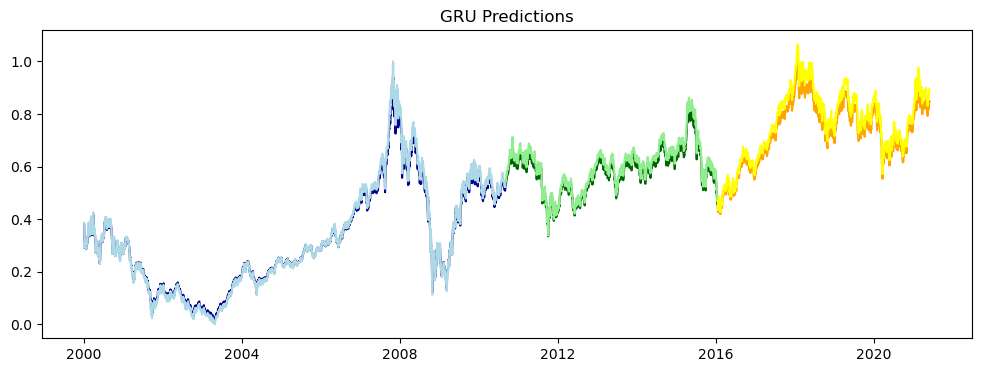

In [90]:
data = {
    "train": train_new, "val": val_new, "test": test_new, 
    "train_preds": train_preds.ravel(), "val_preds": val_preds.ravel(), "test_preds": test_preds.ravel()
}

plot_predictions(data, datetime_indexes_df, "GRU Predictions")

In [81]:
def plot_models_comparison(model_1_history, model_2_history, model_name_1, model_name_2, metric='mae'):
    val_metric = 'val_' + metric
        
    model_1_train_values = model_1_history.history[metric]
    model_1_val_values = model_1_history.history[val_metric]
    model_2_train_values = model_2_history.history[metric]
    model_2_val_values = model_2_history.history[val_metric]
        
    epochs = range(1, len(model_1_train_values) + 1)
        
    plt.figure(figsize=(10,4))
    plt.plot(epochs, model_1_train_values, color='lightblue', label=f'Training {metric}')
    plt.plot(epochs, model_1_val_values, color='pink', label=f'Validation {metric}')
    
    plt.title(f'{model_name_1} performance')
    plt.legend()
    
    plt.figure(figsize=(10,4))
    plt.plot(epochs, model_2_train_values, color='lightblue', label=f'Training {metric}')
    plt.plot(epochs, model_2_val_values, color='pink', label=f'Validation {metric}')
    
    plt.title(f'{model_name_2} performance')
    plt.legend()

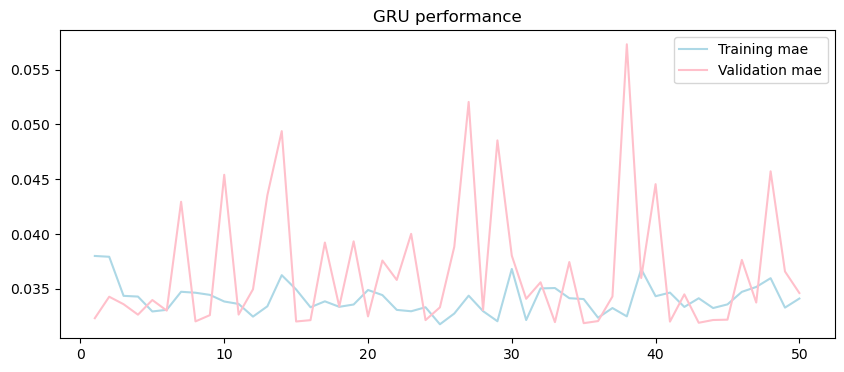

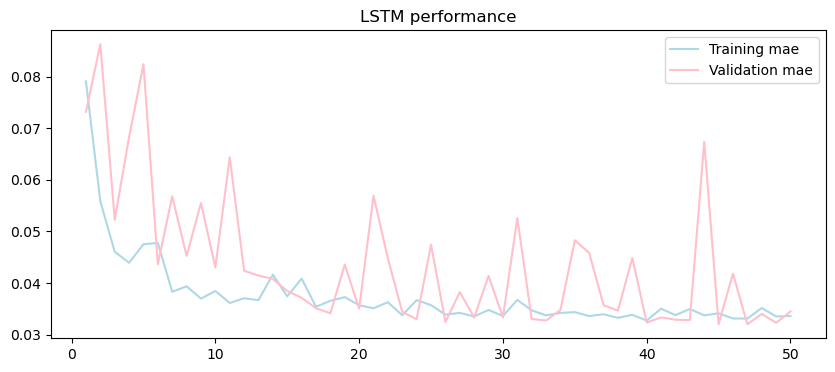

In [82]:
# Comparing the two models regarding MAE:
plot_models_comparison(history_gru_model2_new, history_lstm_model_3, "GRU", "LSTM")

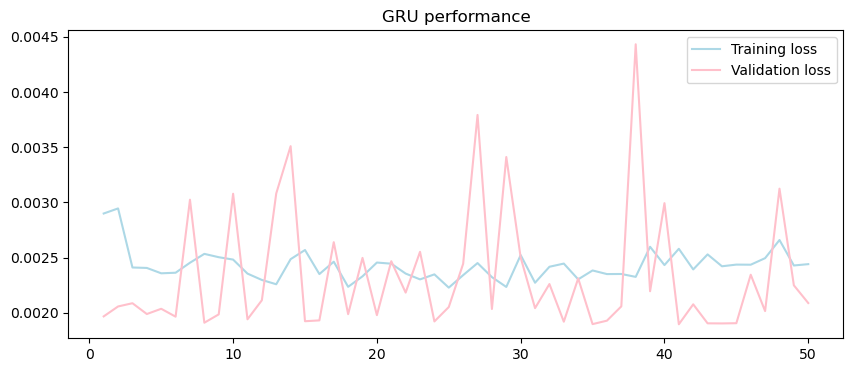

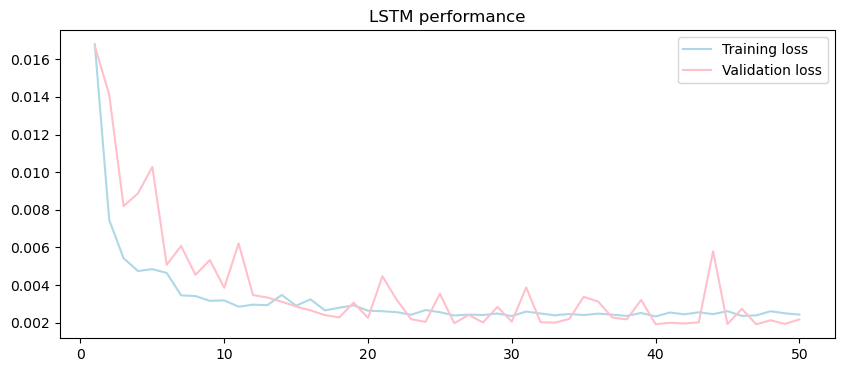

In [83]:
plot_models_comparison(history_gru_model2_new, history_lstm_model_3, "GRU", "LSTM", metric = 'loss')